### Visualize annual steer prices using USDA NASS data

This notebook will create time series visualizations of steer cattle prices, comparing nominal and real price trends. 

Click the badge below to open in Google Colab:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chuckgrigsby0/agec-370/blob/main/notebooks/plot_annual_steer_prices.ipynb)


We first load the cattle price data obtained from USDA NASS and the average BLS CPI-U indices. 

In [ ]:
import pandas as pd
import numpy as np
import google.colab

# Base URL for raw GitHub content
base_url = "https://raw.githubusercontent.com/chuckgrigsby0/agec-370/main/data/"
    
# Load cattle price data directly from GitHub URL
cattle_price_national = pd.read_csv(base_url + 'cattle_price_national_nass.csv')

# Load CPI data directly from GitHub URL
cpi = pd.read_csv(base_url + 'cpi_1913_2024.csv')

### Prepare annual steer price data

In [4]:
select_vars = ['year', 'reference_period_desc', 'begin_code', 'freq_desc',  'unit_desc', 'sector_desc',  'class_desc', 'commodity_desc', 'short_desc', 'statisticcat_desc', 'Value']

cattle_price_sel = cattle_price[select_vars]

Filter cattle data to only include records with "STEERS" in the description. 

This uses str.contains() with regex=True to find any description containing "STEERS"

In [6]:
steer_prices = cattle_price_sel[cattle_price_sel["short_desc"].str.contains('STEERS', regex=True)]

print(steer_prices['short_desc'].unique())

['CATTLE, STEERS & HEIFERS, GE 500 LBS - PRICE RECEIVED, MEASURED IN $ / CWT']


Filter to annual frequency only (exclude monthly, quarterly, etc.).

In [26]:
steer_prices_annual = steer_prices.loc[steer_prices['freq_desc'] == 'ANNUAL'].copy()

Check that we are not missing any years. 

In [27]:
# # Get the years present in the data
actual_years = set(steer_prices_annual['year'].astype(int).unique())


# # Create the full range of expected years
expected_years = set(range(min(actual_years), max(actual_years)+1))  # 2026 to include 2025

# Find missing years
missing_years = expected_years - actual_years


print(f"Missing years: {sorted(missing_years)}")
print(f"Total missing years: {len(missing_years)}")

# Also show the range of years we actually have
print(f"Years available: {min(actual_years)} to {max(actual_years)}")
print(f"Total years available: {len(actual_years)}")

Missing years: []
Total missing years: 0
Years available: 2003 to 2024
Total years available: 22


Convert the 'year' column to integer type for merging with CPI data. The copy() above allows us to modify without SettingWithCopyWarning. 

In [28]:
steer_prices_annual['year'] = steer_prices_annual['year'].astype(int)

Convert the 'Value' column from string to numeric. `errors='coerce'` will convert any non-numeric values (like "(D)" for suppressed data) to `NaN`. 

In [30]:
steer_prices['Value'].eq("'(D)'").any()

np.False_

In [31]:
steer_prices_annual['Value'] = pd.to_numeric(steer_prices_annual['Value'], errors='coerce')

Check for missing values in the `Value` column. 

In [33]:
print(f'''There are {steer_prices_annual['Value'].isna().sum()} missing values in the 'Value' column.''')
# Drop any rows with missing price values
# This removes any observations where the price was suppressed or missing
# steer_prices_annual = steer_prices_annual.dropna(subset=['Value'])

There are 0 missing values in the 'Value' column.


Rename `Value` column to `nominal_price` for clarity. This makes it explicit that these are nominal (not inflation-adjusted) prices. 

In [34]:
steer_prices_annual = steer_prices_annual.rename(columns={'Value': 'nominal_price'})


### Merge CPI data with steer price data to compute real prices


Merge cattle price data with CPI data on year. This combines the price data with the Consumer Price Index for inflation adjustment. `'left'` join keeps all cattle price observations, matching CPI where available. 

In [35]:
steer_prices_annual = steer_prices_annual.merge(
    cpi,  # CPI data loaded earlier
    left_on='year',  # Match on 'year' column in cattle data
    right_on='year',  # Match on 'Year' column in CPI data
    how='left'  # Keep all cattle price records
)

Get the CPI value for the base year (2024). This will be used as the denominator to adjust all prices to 2024 dollars. 

In [36]:
cpi_base_year = cpi[cpi['year'] == 2024]['annual_avg_cpi'].values[0]  # Should be 313.689
print(cpi_base_year)

313.689


Calculate real (inflation-adjusted) prices in 2024 dollars. 

- Formula: Real Price = (Nominal Price / CPI in year t) × CPI in base year
- This adjusts all historical prices to be comparable in 2024 purchasing power

In [37]:
steer_prices_annual['real_price'] = (
    steer_prices_annual['nominal_price'] / steer_prices_annual['annual_avg_cpi']
) * cpi_base_year

### Create Visualization: Scatterplot with regression lines

In [43]:
# Import visualization libraries
import matplotlib.pyplot as plt  # For figure creation and aesthetic enhancements
import seaborn as sns  # For statistical plots with regression lines

# Set the style for seaborn plots
# 'whitegrid' provides a clean background with subtle gridlines
sns.set_style('whitegrid')

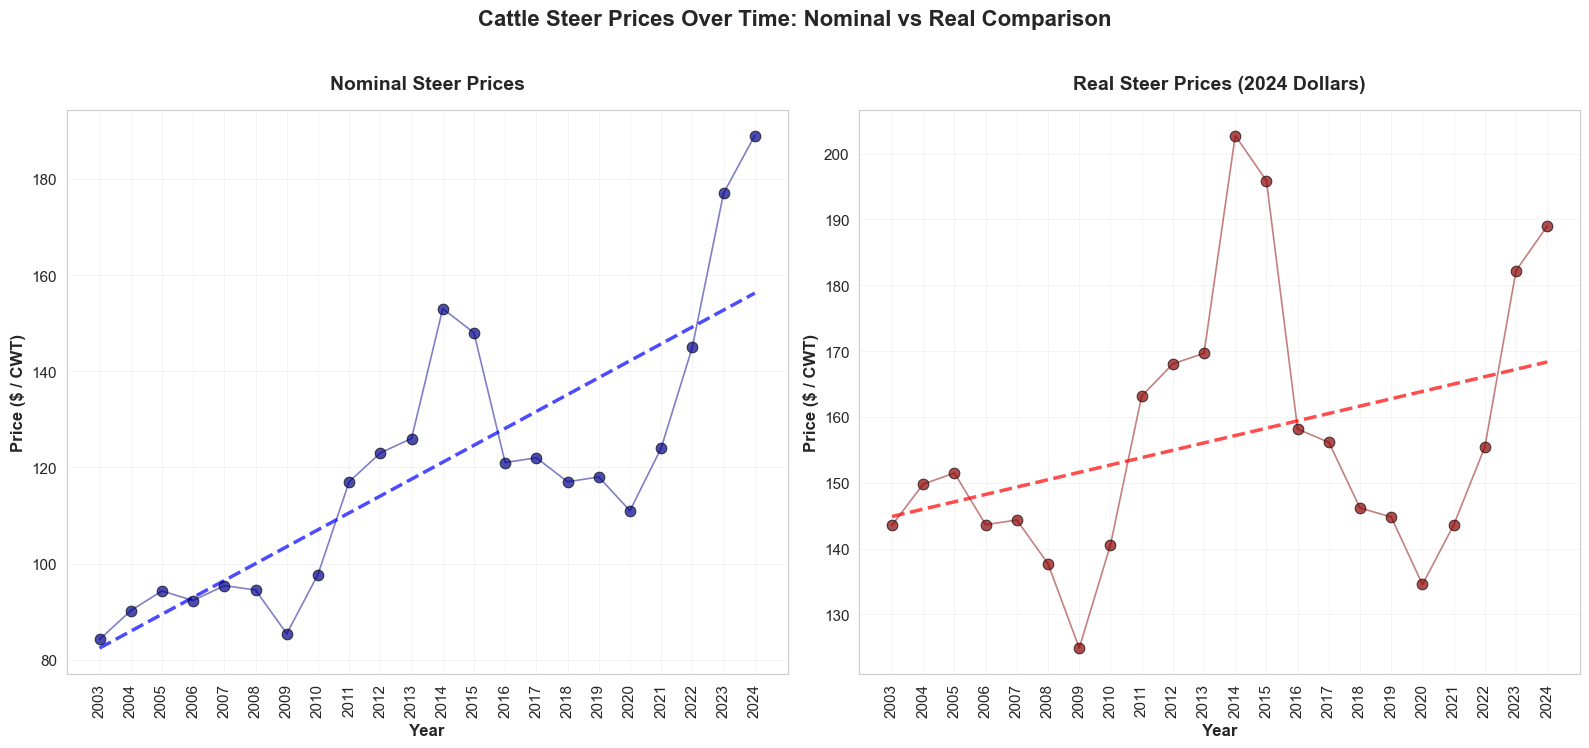

In [ ]:
# Create figure with two subplots side by side
# figsize=(16, 8) creates a wide figure to accommodate two plots
# ncols=2 creates two columns for side-by-side comparison
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# ============================================================
# LEFT PLOT: NOMINAL PRICES
# ============================================================

# Plot nominal prices with regression line
# regplot creates both scatterplot and fitted regression line
# ci=None turns off the confidence interval shading
sns.regplot(
    data=steer_prices_annual,  # Use the merged dataframe
    x='year',  # Year on x-axis
    y='nominal_price',  # Nominal price on y-axis
    scatter_kws={
        'alpha': 0.7,  # Transparency: 0.7 makes points visible but not overpowering
        's': 60,  # Size of scatter points (60 is moderately sized)
        'color': 'darkblue',  # Color for nominal price points
        'edgecolors': 'black',  # Black border around points for definition
        'linewidths': 0.7,  # Border width
        'zorder': 3  # zorder=3 ensures points appear above lines
    },
    line_kws={
        'color': 'blue',  # Blue regression line for nominal prices
        'linewidth': 2.5,  # Thick line for visibility
        'linestyle': '--',  # Dashed line to distinguish from connected line
        'alpha': 0.7,  # Slight transparency
        'zorder': 2  # zorder=2 places regression line above grid but below points
    },
    ci=None,  # Turn off confidence interval shading
    ax=axes[0]  # Plot on first (left) subplot
)

# Add connected line plot to show year-to-year changes
# This connects consecutive years with a line to show temporal progression
axes[0].plot(
    steer_prices_annual['year'],  # X values: years
    steer_prices_annual['nominal_price'],  # Y values: nominal prices
    color='darkblue',  # Match scatter point color
    linewidth=1.2,  # Thin line so it doesn't overpower scatter and regression
    alpha=0.5,  # Semi-transparent to show as background connection
    zorder=1  # zorder=1 places connected line behind everything else
)

# Set title for nominal price subplot
# fontsize=14 makes subtitle prominent, weight='bold' emphasizes it
axes[0].set_title(
    'Nominal Steer Prices',
    fontsize=14,
    weight='bold',
    pad=15  # Add 15 points of padding above title
)

# Set x-axis label for nominal price subplot
axes[0].set_xlabel('Year', fontsize=12, weight='bold')

# Set y-axis label for nominal price subplot
axes[0].set_ylabel('Price ($ / CWT)', fontsize=12, weight='bold')

# Set x-axis to display every year in the dataset
# Get all unique years from the data and sort them
all_years = sorted(steer_prices_annual['year'].unique())
# Set x-tick locations to show every year
axes[0].set_xticks(all_years)
# Set x-tick labels to match the years
axes[0].set_xticklabels(all_years)


# Increase font size of tick labels and rotate x-axis labels to 90 degrees
# labelsize=11 makes year and price values easier to read
# rotation=90 for x-axis makes vertical year labels that don't overlap
# ha='center' aligns rotated labels centered on tick marks
axes[0].tick_params(axis='y', labelsize=11)  # Y-axis tick label size
axes[0].tick_params(axis='x', labelsize=11, rotation=90)  # X-axis: larger labels, 90° rotation

# Add grid for easier reading of values
axes[0].grid(
    axis='both',  # Add gridlines for both x and y axes
    alpha=0.3,  # Make gridlines subtle (30% opacity)
    linestyle='-',  # Use solid lines
    linewidth=0.5  # Make gridlines thin
)
# ============================================================
# RIGHT PLOT: REAL PRICES (2024 DOLLARS)
# ============================================================

# Plot real prices with regression line
# Same structure as nominal plot but for inflation-adjusted prices
sns.regplot(
    data=steer_prices_annual,  # Use the same dataframe
    x='year',  # Year on x-axis
    y='real_price',  # Real (inflation-adjusted) price on y-axis
    scatter_kws={
        'alpha': 0.7,  # Transparency for overlapping visibility
        's': 60,  # Same size as nominal price points for consistency
        'color': 'darkred',  # Red color for real price points
        'edgecolors': 'black',  # Black border around points
        'linewidths': 0.7,  # Border width
        'zorder': 3  # Points appear above lines
    },
    line_kws={
        'color': 'red',  # Red regression line for real prices
        'linewidth': 2.5,  # Thick line for visibility
        'linestyle': '--',  # Dashed line style
        'alpha': 0.7,  # Slight transparency
        'zorder': 2  # Regression line above grid but below points
    },
    ci=None,  # Turn off confidence interval shading
    ax=axes[1]  # Plot on second (right) subplot
)

# Add connected line plot to show year-to-year changes
# Connects consecutive years to show temporal progression for real prices
axes[1].plot(
    steer_prices_annual['year'],  # X values: years
    steer_prices_annual['real_price'],  # Y values: real prices
    color='darkred',  # Match scatter point color
    linewidth=1.2,  # Thin line so it doesn't overpower scatter and regression
    alpha=0.5,  # Semi-transparent to show as background connection
    zorder=1  # Connected line behind everything else
)

# Set title for real price subplot
axes[1].set_title(
    'Real Steer Prices (2024 Dollars)',
    fontsize=14,
    weight='bold',
    pad=15  # Add padding above title
)

# Set x-axis label for real price subplot
axes[1].set_xlabel('Year', fontsize=12, weight='bold')

# Set y-axis label for real price subplot
axes[1].set_ylabel('Price ($ / CWT)', fontsize=12, weight='bold')

# Set x-axis to display every year in the dataset
# Use the same all_years list created above for consistency
axes[1].set_xticks(all_years)
# Set x-tick labels to match the years
axes[1].set_xticklabels(all_years)

# Increase font size of tick labels (numbers on axes)
# labelsize=11 makes year and price values easier to read
axes[1].tick_params(axis='y', labelsize=11)  # Y-axis tick label size
axes[1].tick_params(axis='x', labelsize=11, rotation=90)  # X-axis: larger labels, 90° rotation


# Add grid for easier reading of values
axes[1].grid(
    axis='both',  # Add gridlines for both x and y axes
    alpha=0.3,  # Make gridlines subtle (30% opacity)
    linestyle='-',  # Use solid lines
    linewidth=0.5  # Make gridlines thin
)

# Add main title for entire figure
# This overarching title appears above both subplots
fig.suptitle(
    'Cattle Steer Prices Over Time: Nominal vs Real Comparison',
    fontsize=16,
    weight='bold',
    y=0.98  # Position slightly above subplots (adjusted for taller figure)
)

# Adjust layout to prevent label cutoff and ensure proper spacing
# tight_layout() automatically adjusts subplot parameters for clean appearance
# rect parameter reserves space: [left, bottom, right, top] in figure coordinates
# bottom=0.15 provides extra space at bottom for rotated year labels
plt.tight_layout(rect=[0, 0.05, 1, 0.96])